In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pickle
%matplotlib inline

In [2]:
def save_model(model, filename):
    '''
    This function takes as input a trained model, and a filename.
    The model is stored in the new file specified by filename, if
    such a file already exists, nothing is returned.
    '''
    if os.path.exists(filename):
        print("The file '" + filename + "' already exists in the cwd")
        return
    with open(filename, 'w') as fp:
        pickle.dump(model, fp)
    
def load_model(filename):
    '''
    This function takes as input a filename of a file which
    contains a trained model, and returns the model.
    If no such file exists, nothing is returned.
    '''
    if not os.path.exists(filename):
        print("The file '" + filename + "' does not exist in the cwd")
        return
    with open(filename, 'r') as fp:
        model = pickle.load(fp)
    return model

def plotHeatmap(x, size):
    '''
    This function takes as input a vector 'x' and the 
    size to which it'll be reshaped (i.e. it'll become 
    a size x size matrix), and plots the heatmap of x.
    '''
    fig = plt.figure()
    ax = fig.gca()
    gray_scale_img = x.reshape((size, size))
    heatmap = ax.imshow(gray_scale_img, cmap = mpl.cm.coolwarm)
    fig.colorbar(heatmap, shrink = 0.5, aspect=5)
    plt.show()

def plotImages(matrix):
    '''
    This functions takes as input a 2d array 'matrix' where 
    all the subarrays of matrix have the same length and contain
    images of the same dimensionality (all of which will be 
    resized to 28x28), and plots an aggregated view of the images.
    '''
    num_rows = len(matrix)
    num_cols = len(matrix[0])
    fig = plt.figure()
    idx = 1
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            plt.subplot(num_rows, num_cols, idx)
            idx += 1
            plt.imshow(matrix[i][j].reshape((28,28)), cmap="gray")
            plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print('Number of training examples: ', str(mnist.train.images.shape[0]))
print('Number of testing examples: ', str(mnist.test.images.shape[0]))
print('Shape of training images: ', str(mnist.train.images.shape))
print('Shape of training labels: ', str(mnist.train.labels.shape))
print('Shape of testing images: ', str(mnist.test.images.shape))
print('Shape of testing labels: ', str(mnist.test.labels.shape))

('Number of training examples: ', '55000')
('Number of testing examples: ', '10000')
('Shape of training images: ', '(55000, 784)')
('Shape of training labels: ', '(55000, 10)')
('Shape of testing images: ', '(10000, 784)')
('Shape of testing labels: ', '(10000, 10)')


label = 9


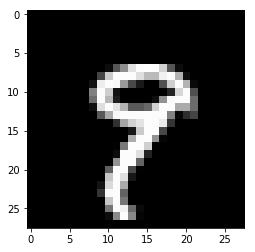

In [41]:
# Example of a picture
index = 159
plt.imshow(mnist.train.images[index].reshape(28,28), cmap="gray")
print ("label = " + str(mnist.train.labels[index].argmax()))

In [6]:
def create_placeholders(n_H0, n_W0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_y -- scalar, number of classes
    """
    X = tf.placeholder(dtype = tf.float32, shape = [None, n_H0 * n_W0]) # 28 x 28 pixels
    Y = tf.placeholder(dtype = tf.float32, shape = [None, n_y]) # 10 labels   
    return X, Y

In [7]:
x, y_ = create_placeholders(28, 28, 10)
print ("x = " + str(x))
print ("y_ = " + str(y_))

x = Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
y_ = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [8]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. 
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    W1 = tf.get_variable("W1", [5, 5, 1, 32], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [5, 5, 32, 64], initializer = tf.contrib.layers.xavier_initializer())
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [9]:
parameters = initialize_parameters()

In [10]:
# Start to build a multilayer CNN:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding= 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],
                          padding = 'SAME')

In [11]:
def forward_propagation(x, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    # Implements the forward propagation for the model:
    #     CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    # THIS IS THE FIRST CONV LAYER:
    # The shape has four paras, the first two are the patch size,
    # the third one is the number of input channels, the last one
    # is the number of output channels.
    W_conv1 = weight_variable(W1.shape) # [5, 5, 1, 32]
    # bias has a vector, each output channel has one bias
    b_conv1 = bias_variable([W1.shape[3]]) # 32
    # Reshape the input image, the 2 and 3 paras are width and height,
    # the last para is the number of input image channel
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    # do the convolve and plus bias and apply relu func
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    # do the max pooling operation
    h_pool1 = max_pool_2x2(h_conv1)
    # THIS IS THE SECOND CONV LAYER:
    W_conv2 = weight_variable(W2.shape) # [5, 5, 32, 64]
    b_conv2 = bias_variable([W2.shape[3]]) # 64
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # THIS IS DENSELY CONNECTED LAYER:
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    # THIS IS DROPOUT:
    # We keep a placeholder for threshold of dropout, turn it on when
    # training, and turn if off when testing
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    # THIS IS READOUT LAYER:
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    # Probabilities - output from model (not the same as logits)
    y = tf.nn.softmax(y_conv)
    return y_conv, y, keep_prob

In [14]:
y_conv, y, keep_prob = forward_propagation(x, parameters)

In [15]:
def compute_cost(y_conv, y_):
    # TRAIN AND EVALUATE THE MODEL
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    return cross_entropy

In [16]:
cost = compute_cost(y_conv, y_)

In [21]:
x, y_ = create_placeholders(28, 28, 10)

parameters = initialize_parameters()

y_conv, y, keep_prob = forward_propagation(x, parameters)

cost = compute_cost(y_conv, y_)

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

saver = tf.train.Saver()

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize all the variables globally
init = tf.global_variables_initializer()

# Run the initialization
sess.run(init)
for i in range(200):
    batch = mnist.train.next_batch(50)
    if i % 200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    optimizer.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    # test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    # print('test accuracy %g' % (test_accuracy))
np.savez("model1.npy", parameters)

In [22]:
train_accuracy, test_accuracy, parameters = model()

step 0, training accuracy 0.1
test accuracy 0.9021
Model saved in path: model_saved.ckpt


TypeError: can't pickle module objects

In [42]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})

    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)

    # Setup image grid
    import math
    cols = 3
    rows = int(math.ceil(image_list.shape[0]/cols))
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )

    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image, cmap="gray")

        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))

        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")

    plt.show()
    
    return prob if output_probs else None

In [43]:
# Get 9 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 9 [0:9]
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:9]
x_batch = mnist.test.images[index_of_2s]

In [44]:
plot_predictions(x_batch)

NameError: name 'sess' is not defined

In [111]:
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step

In [112]:
# Pick a random 2 image from first 1000 images 
# Create adversarial image and with target label 6
index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
rand_index = np.random.randint(0, len(index_of_2s))
image_norm = mnist.test.images[index_of_2s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,1,0,0,0] # one hot encoded, adversarial label 6

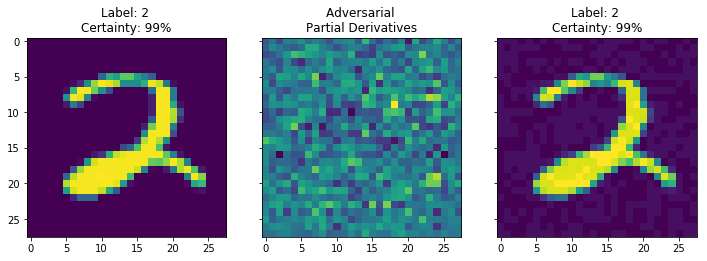

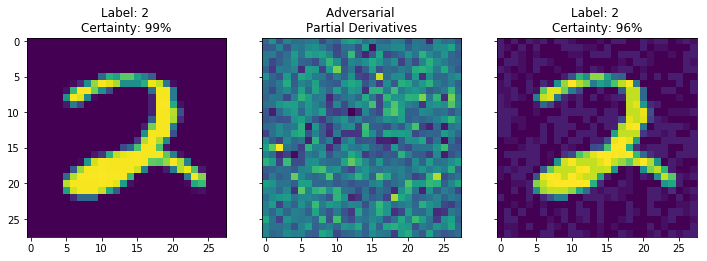

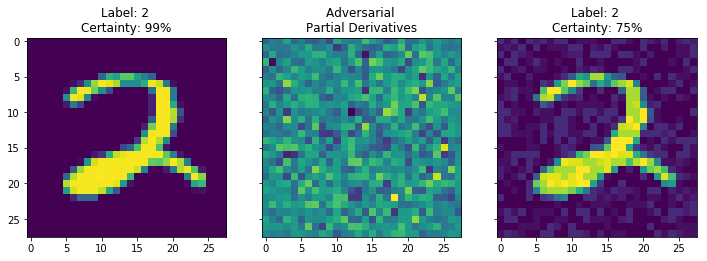

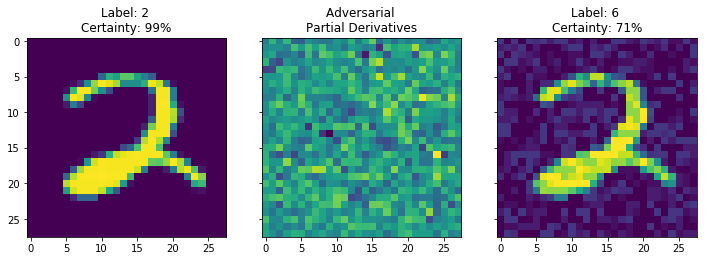

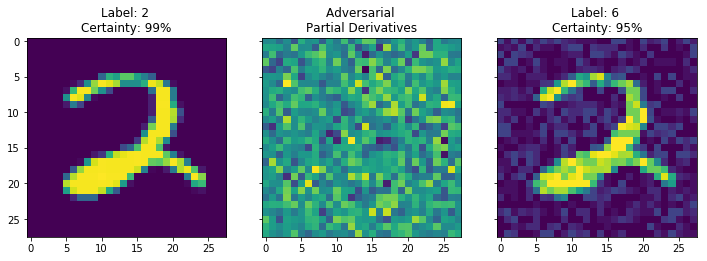

[]

In [113]:
# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
create_plot_adversarial_images(image_norm, label_adv, lr=0.2, n_steps=5)